In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sn
from matplotlib import pyplot as plt
import statsmodels.api as sm
from pylab import rcParams

In [2]:
#Read the csv file
df=pd.read_csv('merged_data.csv',parse_dates=['mkt_datetime'])

In [3]:
df=df[:23376]

In [4]:
df.head(2)

,mkt_datetime,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
0,2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
1,2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0


In [5]:
#Variables for training
cols = list(df)[0:13]
uni_df=df[cols]
uni_df.set_index('mkt_datetime', inplace=True)

In [6]:
uni_df.head(2)

,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
mkt_datetime,,,,,,,,,,,,
2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0


In [7]:
y = uni_df['ont_ene'].resample('MS').mean()

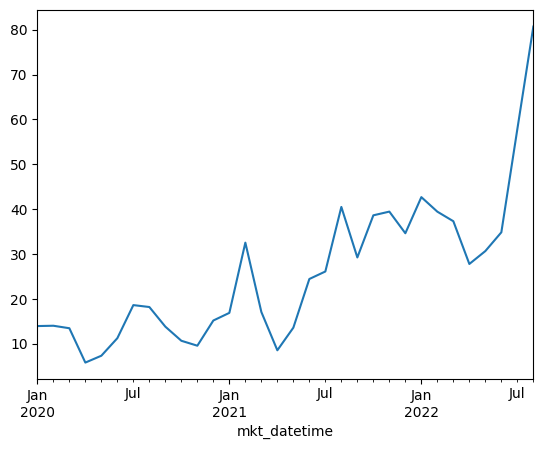

In [8]:
y.plot()
plt.show()

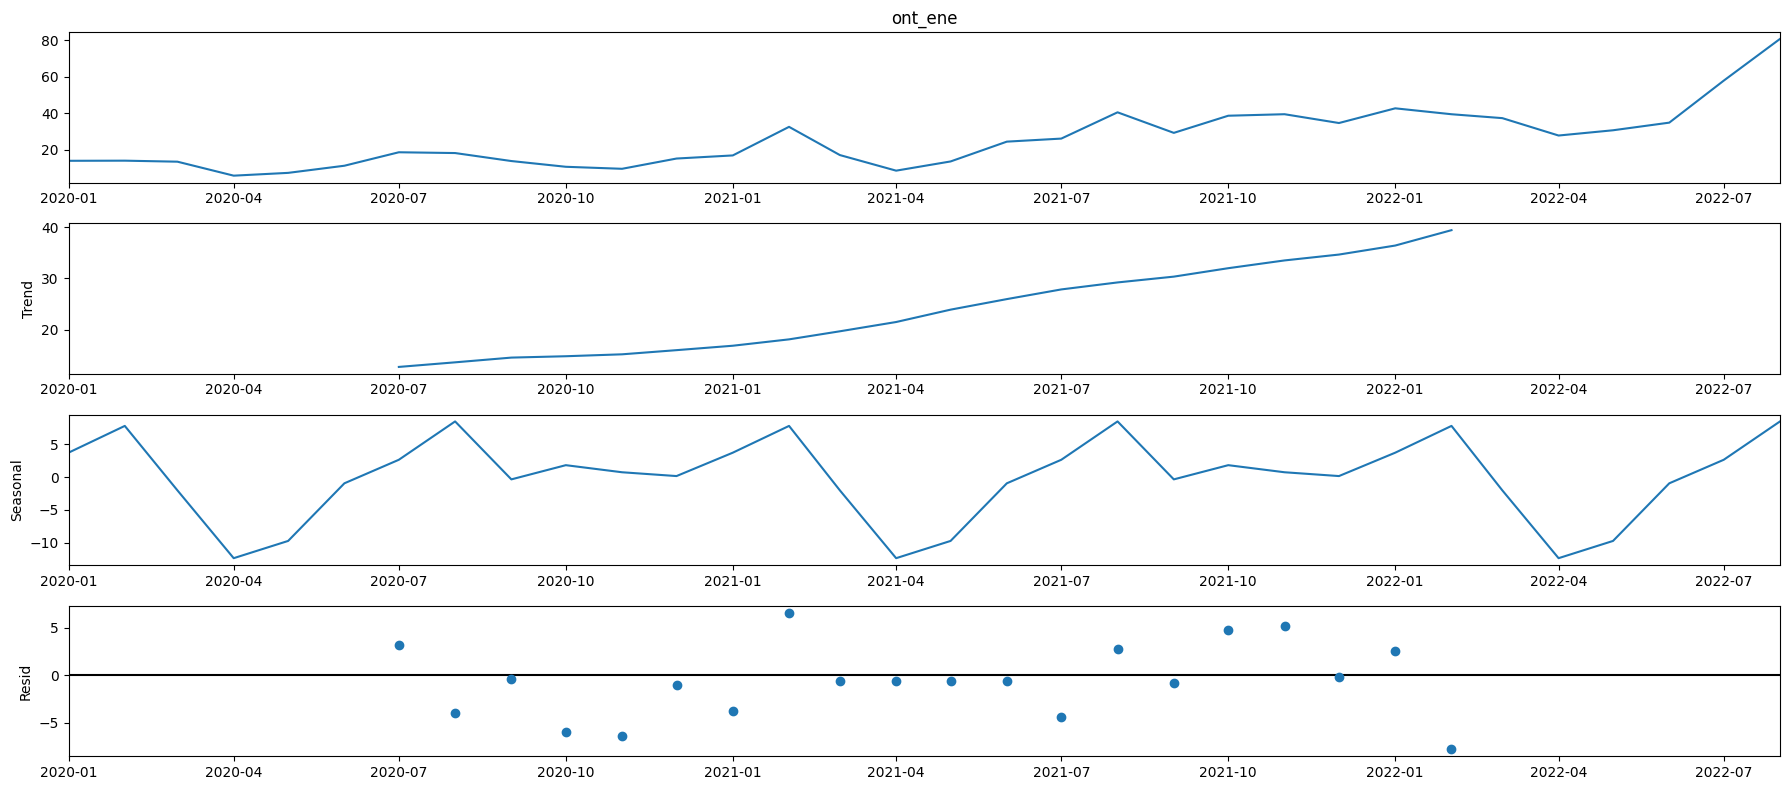

In [9]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [10]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
uni_df_scaled = sc.fit_transform(uni_df)

In [11]:
print(uni_df_scaled[0])

[0.90782302 0.0141516  0.20030311 0.46185792 0.         0.
 0.00349108 0.227      0.53188999 0.26571429 0.42241379 0.0027082 ]


In [12]:
# uni_df.head(1)

In [13]:
# uni_df.describe()

In [14]:
# split into train and test sets
# train_size = int(len(uni_df) * 0.8)
train_size=2*365*24
test_size = len(uni_df) - train_size
train, test = uni_df_scaled[0:train_size,:], uni_df_scaled[train_size:len(uni_df),:]

In [15]:
train_size

17520

In [16]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), :]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 11])
    return np.array(data_x), np.array(data_y)

In [17]:
# reshape into X=t and Y=t+1
look_back =48
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [18]:
# groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# i = 1
# # plot each column
# values=uni_df.values
# plt.figure(figsize=(14, 10))
# for group in groups:
# 	plt.subplot(len(groups), 1, i)
# 	plt.plot(values[:1000, group])
# 	plt.title(uni_df.columns[group], y=0.5, loc='right')
# 	i += 1
# plt.show()

In [19]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 60)            17520     
                                                                 
 dropout (Dropout)           (None, 48, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 48, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 40, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/40
728/728 [==============================] - 95s 116ms/step - loss: 0.0094 - val_loss: 0.0142 - lr: 0.0010
Epoch 2/40
728/728 [==============================] - 95s 130ms/step - loss: 0.0058 - val_loss: 0.0136 - lr: 0.0010
Epoch 3/40
728/728 [==============================] - 86s 118ms/step - loss: 0.0052 - val_loss: 0.0138 - lr: 0.0010
Epoch 4/40
728/728 [==============================] - 82s 113ms/step - loss: 0.0050 - val_loss: 0.0135 - lr: 0.0010
Epoch 5/40
728/728 [==============================] - 82s 112ms/step - loss: 0.0047 - val_loss: 0.0131 - lr: 0.0010
Epoch 6/40
728/728 [==============================] - 81s 111ms/step - loss: 0.0046 - val_loss: 0.0132 - lr: 0.0010
Epoch 7/40
728/728 [==============================] - 80s 110ms/step - loss: 0.0045 - val_loss: 0.0131 - lr: 0.0010
Epoch 8/40
728/728 [==============================] - 93s 128ms/step - loss: 0.0045 - val_loss: 0.0128 - lr: 0.0010
Epoch 9/40
728/728 [==============================] - 103s 142ms/step - 

In [21]:
regressor.save('lstm_multi_model5')

INFO:tensorflow:Assets written to: lstm_multi_model5/assets


INFO:tensorflow:Assets written to: lstm_multi_model5/assets


In [69]:
# regressor = tf.keras.models.load_model('lstm_multi_model4')

In [22]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

182/182 [==============================] - 4s 21ms/step


In [23]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [24]:
colNames=list(uni_df)
colName='ont_ene'

In [25]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

Train Mean Absolute Error: 8.116447392516992
Train Root Mean Squared Error: 22.73982822252371
Test Mean Absolute Error: 13.320745986324294
Test Root Mean Squared Error: 27.34180855974644


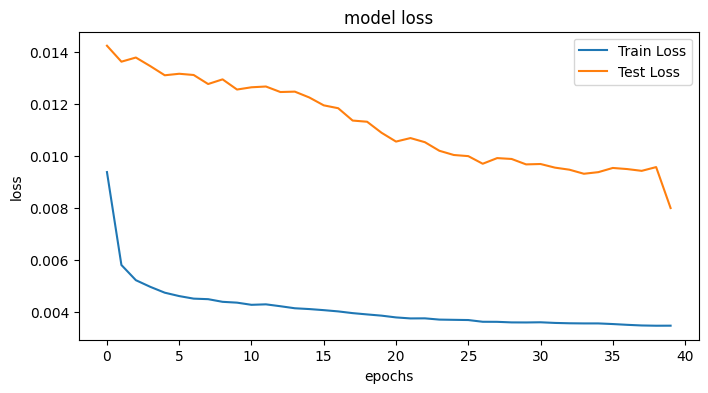

In [26]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [27]:
# lstm_20=test_predict

In [1]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[0:180], marker='.', label="actual")
plt.plot(aa, test_predict[:180], 'r', label="prediction")
# plt.plot(aa, lstm_20[2000:2180], 'green', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step (hour)', size=15)
plt.legend(fontsize=15)
plt.show();

NameError: name 'plt' is not defined

In [93]:
Y_test_inv.shape

(5807,)

In [77]:
d={'Timestamp':df.mkt_datetime[17568:23375],'original':Y_test_inv,'predicted':test_predict}
price_df=pd.DataFrame(d)

In [78]:
final=price_df.round(2)

In [ ]:
final.to_csv('val_predictions.csv',index=False)

In [ ]:
regressor = Sequential()

regressor.add(GRU(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

In [ ]:
regressor.save('gru_multi_model')

In [ ]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [ ]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [ ]:
colNames=list(uni_df)
colName='ont_ene'

In [ ]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[1000:1180], marker='.', label="actual")
plt.plot(aa, test_predict[1000:1180], 'r', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step (hour)', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('R2 Score: ', r2_score(Y_test_inv, test_predict))